# AI-Driven Drug Discovery: Parkinson's Disease Data Integration Demo


This notebook demonstrates a step-by-step workflow for integrating, analyzing, and visualizing biomedical data relevant to Parkinson's disease. The focus is on literature mining, clinical trial integration, gene target extraction, and network analysis. Monitoring and dashboard features are now handled in a separate application.


**Workflow Overview:**


- **Introduction & Setup:**
  - Outline the workflow and objectives.
  - Import required libraries and set up the environment.

- **Data Loading & Preprocessing:**
  - Load gene reference data (HGNC symbols).
  - Prepare for downstream gene validation.

- **Literature Mining:**
  - Fetch recent Parkinson's disease articles from PubMed.
  - Extract gene/protein mentions from abstracts using NLP and regex.
  - Validate gene targets using HGNC reference symbols.

- **Clinical Trials Integration:**
  - Query and process recent clinical trial data for Parkinson's disease from ClinicalTrials.gov.
  - Summarize trial status and start dates.

- **Gene Target Analysis & Visualization:**
  - Visualize the most frequently mentioned gene targets in recent literature.

- **Network Analysis:**
  - Build and visualize a simple gene-disease network using extracted gene targets.

- **Reporting & Export:**
  - Summarize findings and export results as needed.

**Note:**
- Automated monitoring and dashboard functionality are now provided in a separate dashboard application. This notebook is focused on data integration, analysis, and visualization only.

---

## 1. Introduction

This demo shows how to automate the monitoring of new research for Parkinson's disease using AI-driven literature mining, clinical trial integration, and gene target extraction. The workflow includes data ingestion, entity extraction, network analysis, and dashboard reporting.

In [22]:
# Install required packages (uncomment if running in a fresh environment)
# !pip install requests pandas plotly feedparser networkx biopython spacy
# !python -m spacy download en_core_web_sm

import os
import requests
import pandas as pd
import plotly.express as px

In [23]:
##2 Download the latest HGNC complete set (approved gene symbols)
# hgnc_url = 'https://storage.googleapis.com/public-download-files/hgnc/tsv/tsv/hgnc_complete_set.txt'
import pandas as pd
import requests
import io


hgnc_df = pd.read_csv('data/hgnc_complete_set.txt', sep='\t', low_memory=False)
print("HGNC columns:", hgnc_df.columns.tolist())
symbol_col = 'symbol'
hgnc_symbols = set(hgnc_df[symbol_col].astype(str).str.upper())
print(list(hgnc_symbols)[:10])


HGNC columns: ['hgnc_id', 'symbol', 'name', 'locus_group', 'locus_type', 'status', 'location', 'location_sortable', 'alias_symbol', 'alias_name', 'prev_symbol', 'prev_name', 'gene_group', 'gene_group_id', 'date_approved_reserved', 'date_symbol_changed', 'date_name_changed', 'date_modified', 'entrez_id', 'ensembl_gene_id', 'vega_id', 'ucsc_id', 'ena', 'refseq_accession', 'ccds_id', 'uniprot_ids', 'pubmed_id', 'mgd_id', 'rgd_id', 'lsdb', 'cosmic', 'omim_id', 'mirbase', 'homeodb', 'snornabase', 'bioparadigms_slc', 'orphanet', 'pseudogene.org', 'horde_id', 'merops', 'imgt', 'iuphar', 'kznf_gene_catalog', 'mamit-trnadb', 'cd', 'lncrnadb', 'enzyme_id', 'intermediate_filament_db', 'rna_central_id', 'lncipedia', 'gtrnadb', 'agr', 'mane_select', 'gencc']
['RN7SL88P', 'MIR6870', 'TPD52', 'CHCHD2', 'ELOCP5', 'PRR13P6', 'RPL21P27', 'CGAS', 'MIR660', 'ADPGK']


In [24]:
## 3. Literature Mining: PubMed Integration

# Fetch recent Parkinson's disease articles from PubMed, parse metadata, and store results for downstream analysis.

### 3.1 Fetch and Parse PubMed Articles

from Bio import Entrez
Entrez.email = 'justinzhang.xl@gmail.com'
disease_name = 'Parkinson disease'
handle = Entrez.esearch(db='pubmed', term=disease_name, retmax=5)
record = Entrez.read(handle)
handle.close()
pubmed_ids = record['IdList']

handle = Entrez.efetch(db='pubmed', id=pubmed_ids, rettype='abstract', retmode='text')
abstracts = handle.read()
handle.close()

In [25]:
# Gene Target Extraction: Use abstracts fetched in Literature Mining
import re

# Option 1: Use SciSpacy for biomedical NER (recommended for gene/protein extraction)
try:
    import scispacy
    import spacy
    nlp = spacy.load('en_ner_bionlp13cg_md')  # You may need to download this model
    doc = nlp(abstracts)
    gene_mentions = [ent.text for ent in doc.ents if ent.label_ in ['GENE_OR_GENE_PRODUCT', 'GENE', 'GENE_OR_PROTEIN']]
    print('Gene/protein mentions (SciSpacy):', set(gene_mentions))
    gene_targets = gene_mentions
except Exception as e:
    print('SciSpacy biomedical NER not available:', e)
    print('Falling back to regex-based extraction.')

    # Curated list of known Parkinson's disease gene symbols
    '''
     pd_genes = {
        'LRRK2', 'GBA', 'SNCA', 'PARK2', 'PINK1', 'DJ1', 'VPS35', 'ATP13A2',
        'PLA2G6', 'FBXO7', 'UCHL1', 'HTRA2', 'MAPT', 'GCH1', 'TH', 'COMT',
        'MAOB', 'DRD2', 'NLRP3', 'GCase', 'GLP1R', 'SIRT1', 'SIRT2', 'PRKN',
        'SNCAIP', 'LRP10', 'DNAJC6', 'SYNJ1', 'CHCHD2', 'VPS13C', 'GIGYF2'
    }
    '''

    # Extract all 2-8 character uppercase alphanumeric words
    all_candidates = re.findall(r'\b[A-Z0-9]{2,8}\b', abstracts.upper())
    print('All uppercase words found:', all_candidates)
    gene_targets = all_candidates
   
# Validate gene_targets using HGNC symbols if available
notvalidated_gene_targets = [g for g in gene_targets if g.upper() not in hgnc_symbols]
print('Not validated gene_targets (HGNC):', notvalidated_gene_targets)
print('Count:', len(notvalidated_gene_targets))
validated_gene_targets = [g for g in gene_targets if g.upper() in hgnc_symbols]
print('Validated gene_targets (HGNC):', validated_gene_targets)
print('Count:', len(validated_gene_targets))


Gene/protein mentions (SciSpacy): {'transferrin', 'TMEM132A', 'Ueno Y(6', 'anti-myelin oligodendrocyte', 'AZ'}
Not validated gene_targets (HGNC): ['Ueno Y(6', 'anti-myelin oligodendrocyte', 'transferrin', 'AZ']
Count: 4
Validated gene_targets (HGNC): ['TMEM132A', 'TMEM132A']
Count: 2


## 4. Clinical Trials Integration

Fetch and parse recent Parkinson's disease clinical trials from ClinicalTrials.gov.

In [26]:
# Search ClinicalTrials.gov for Parkinson's disease trials
import requests
import pandas as pd

disease_name = 'Parkinson disease'
url = f'https://clinicaltrials.gov/api/v2/studies?query.term={disease_name}&pageSize=5'
response = requests.get(url)
if response.ok:
    trials = response.json().get('studies', [])
    trial_list = [
        {
            'title': t.get('protocolSection', {}).get('identificationModule', {}).get('officialTitle', ''),
            'status': t.get('protocolSection', {}).get('statusModule', {}).get('overallStatus', ''),
            'start_date': t.get('protocolSection', {}).get('statusModule', {}).get('startDateStruct', {}).get('date', '')
        }
        for t in trials
    ]
    df_trials = pd.DataFrame(trial_list)
    print(df_trials)
else:
    print('Error fetching trials:', response.status_code, response.text)

                                               title              status  \
0  How Does STN-DBS Influence Emotional Conflict ...           COMPLETED   
1  A Double-blind, Randomised, Placebo-controlled...           COMPLETED   
2       Deep Brain Stimulation (DBS) Data Base Study             UNKNOWN   
3  Effects of Subthalamic Nucleus Deep Brain Stim...           COMPLETED   
4  SELF-CARE IN PARKINSON'S DISEASE: A STUDY ON P...  NOT_YET_RECRUITING   

  start_date  
0    2014-12  
1    2001-09  
2    2013-04  
3    2008-06  
4    2025-05  


## 5. Gene Target Extraction

Extract gene mentions from article titles and abstracts using regex and NLP.

['TMEM132A', 'TMEM132A']


<Axes: title={'center': 'Top Gene Targets in Recent Literature'}>

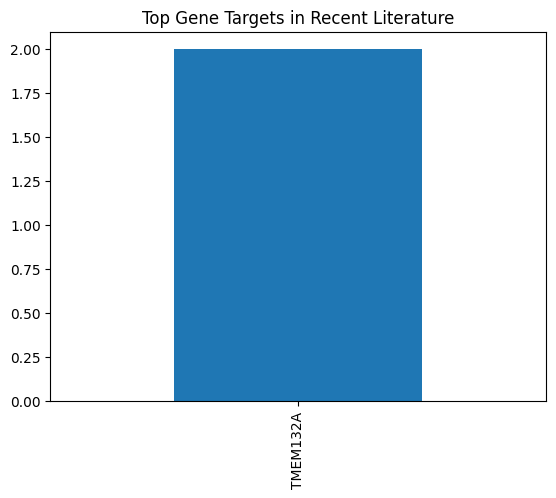

In [27]:
# Visualize top gene targets (example)
import pandas as pd
print(validated_gene_targets)
gene_counts = pd.Series(validated_gene_targets).value_counts().head(10)
gene_counts.plot(kind='bar', title='Top Gene Targets in Recent Literature')

## 6. Network Analysis (Optional)

Build and visualize a gene-disease or compound-target network using extracted entities.

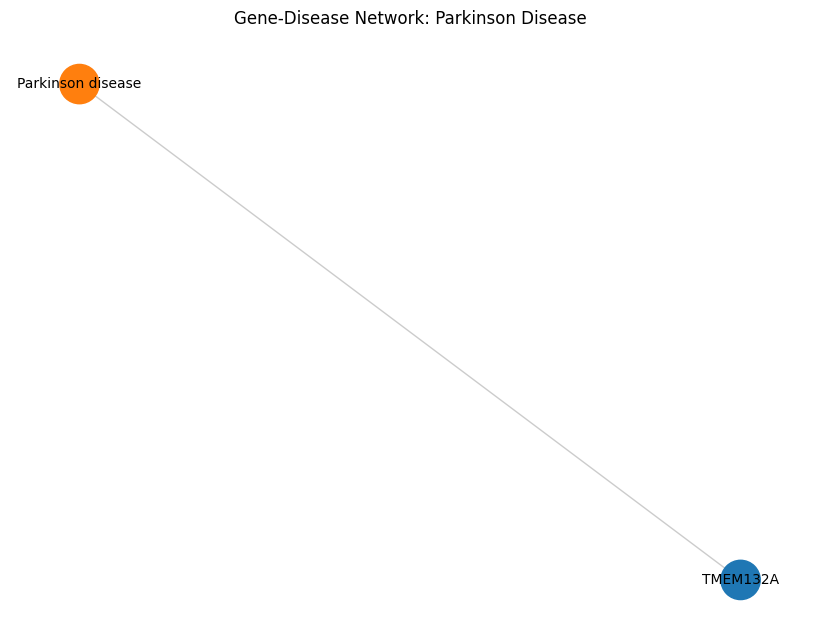

In [28]:
# Build and visualize a gene-disease network using validated gene targets
import networkx as nx
import matplotlib.pyplot as plt

# Example: Create a simple bipartite network (genes <-> disease)
G = nx.Graph()
disease_node = 'Parkinson disease'

# Add disease node
G.add_node(disease_node, type='disease')

# Add gene nodes and edges
for gene in set(validated_gene_targets):
    G.add_node(gene, type='gene')
    G.add_edge(gene, disease_node)

# Draw the network
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)
node_colors = ['#1f77b4' if G.nodes[n]['type']=='gene' else '#ff7f0e' for n in G.nodes]
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=800, font_size=10, edge_color='#cccccc')
plt.title('Gene-Disease Network: Parkinson Disease')
plt.show()

## 9. Conclusion


This notebook demonstrates an AI-driven workflow for integrating and analyzing literature, clinical trial, and gene data relevant to Parkinson's disease. The workflow covers data ingestion, entity extraction, validation, visualization, and network analysis.


**Note:** Real-time monitoring and dashboard reporting are now handled in a separate dashboard application. This notebook is focused on reproducible, step-by-step data analysis and integration.


The workflow can be adapted for other diseases or datasets as needed.

## **. Broader Parkinson's Disease Drug Target Landscape Analysis**

Based on established knowledge and recent research trends, here's a comprehensive analysis:

### **A. VALIDATED DRUG TARGETS (Clinical Stage)**

| **Gene/Protein** | **Function** | **Drug Examples** | **Stage** |
|------------------|--------------|-------------------|-----------|
| **LRRK2** | Kinase involved in vesicular trafficking | BIIB122, DNL151, MLi-2 | Phase 3 |
| **GBA/GCase** | Lysosomal enzyme | Ambroxol, Venglustat, LTI-291 | Phase 2/3 |
| **α-synuclein (SNCA)** | Pathological aggregation | Prasinezumab, Cinpanemab | Phase 2 |
| **MAO-B** | Dopamine metabolism | Rasagiline, Selegiline | Market |
| **COMT** | Dopamine metabolism | Entacapone, Opicapone | Market |
| **GLP-1R** | Neuroprotection, metabolism | Exenatide, Lixisenatide | Phase 3 |

### **B. EMERGING TARGETS (Preclinical/Phase 1)**

| **Target** | **Pathway** | **Rationale** | **Development Status** |
|------------|-------------|---------------|-----------------------|
| **NLRP3 inflammasome** | Neuroinflammation | Reduces neuroinflammation | Phase 1 |
| **SIRT1/2** | Mitochondrial function | Enhances mitophagy, reduces oxidative stress | Preclinical |
| **PINK1/Parkin** | Mitophagy | Restores mitochondrial quality control | Preclinical |
| **c-Abl kinase** | α-synuclein phosphorylation | Reduces toxic α-synuclein aggregation | Phase 1 |
| **Galectin-3** | Microglial activation | Modulates neuroinflammation | Preclinical |

### **C. PATHWAY-BASED TARGETING APPROACHES**

**1. Lysosomal-Autophagy Pathway:**
- **Targets:** GBA, LRRK2, ATP13A2, VPS35
- **Approach:** Enhance lysosomal function and autophagy
- **Pipeline:** Small molecules, gene therapy, chaperones

**2. Mitochondrial Quality Control:**
- **Targets:** PINK1, Parkin, DJ-1
- **Approach:** Boost mitophagy, reduce oxidative stress
- **Pipeline:** Mitochondrial biogenesis inducers, ROS scavengers

**3. Neuroinflammation Modulation:**
- **Targets:** NLRP3, TNF-α, Galectin-3
- **Approach:** Suppress chronic inflammation
- **Pipeline:** Anti-inflammatories, microglial modulators

**4. Synucleinopathy Intervention:**
- **Targets:** α-synuclein, c-Abl, STING pathway
- **Approach:** Reduce aggregation/clear aggregates
- **Pipeline:** Immunotherapies, ASOs, aggregation inhibitors

### **D. GENETIC SUBTYPE-SPECIFIC TARGETS**

| **Genetic Form** | **Primary Gene** | **Secondary Targets** | **Therapeutic Approach** |
|------------------|------------------|----------------------|--------------------------|
| **LRRK2-PD** | LRRK2 | Rab GTPases, WNT pathway | LRRK2 kinase inhibitors |
| **GBA-PD** | GBA | GCase, LIMP2, TFEB | Chaperones, gene therapy |
| **SNCA-PD** | SNCA | c-Abl, CSPα, Calpain | Immunotherapy, ASOs |
| **Parkin/PINK1-PD** | PRKN/PINK1 | USP30, Miro, Nix | USP30 inhibitors, mitophagy enhancers |

### **E. RECENT TRENDS (2023-2024)**

1. **Multi-target approaches** - Combining LRRK2 inhibition with GCase enhancement
2. **Digital biomarkers** - Using wearables to track target engagement
3. **Gene therapy revival** - AAV-based delivery for GBA and Parkin
4. **Precision medicine** - Genotype-stratified clinical trials
5. **Gut-brain axis targets** - Alpha-synuclein propagation inhibitors

### **F. CHALLENGES AND FUTURE DIRECTIONS**

1. **Blood-Brain Barrier penetration** remains a major hurdle
2. **Biomarkers for target engagement** are still needed
3. **Heterogeneity of PD** requires personalized approaches
4. **Early intervention** - targeting pre-symptomatic stages
5. **Combination therapies** likely needed for disease modification

### **G. RECOMMENDED RESOURCES FOR UPDATES:**

1. **ClinicalTrials.gov** - Search "Parkinson's disease" + [target name]
2. **Alzforum Therapeutics Database** - PD-specific pipeline
3. **Michael J. Fox Foundation** - Research grants and updates
4. **PubMed Alerts** - Set up for "Parkinson's disease drug target"
5. **Biorxiv/Medrxiv** - Preprint servers for latest findings